In [1]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import quandl
import urllib3

In [2]:
# Obtain Raw Data
# Use Quandl API to obtain data as far back as free access allows
# Data for 3M

quandl.ApiConfig.api_key = 'MZRHn98qGsdr9wzs79mP'
df_MMM = quandl.get_table('WIKI/PRICES', ticker = ['MMM'], date = { 'gte': '1980-01-01', 'lte': '2020-11-12' })

#df = quandl.get_table('WIKI/PRICES', ticker = ['MMM', 'BA','CAT', 'CVX', 'XOM', 'GE', 'F', 'HON', 'HD', 'NKE'], date = { 'gte': '2008-01-01', 'lte': '2020-11-12' })
#df_MMM

In [3]:
# Task 1: Delete unwanted columns
df_MMM.drop(df_MMM.columns[[7,8]], axis=1, inplace=True)
#df_MMM

In [7]:
# Task 2: Introduce features to dataset 

# Feature 1: Introduce Stock Volatility

# What is it? This is a measure of the range that the stock price bounces around during a day on the market
# Why can it be important? If the stock bounces around more, can it close at a higher price more often?
df_MMM['volatility-calc'] = df_MMM.adj_high - df_MMM.adj_low

# Feature 2: Introduce Rate of Change Volatility

# What is it? This is a measure of the change in the range that a stock price bounces around during the market day
# Why can it be important? If the stock bounce keeps changing, can it close at a higher price more often?
df_MMM['ROC_Volatility']=df_MMM['volatility-calc'].diff()

# Feature 3: Introduce 10-Day Simple Moving Average

# What is it? Quick 10-day lookback at stock closing price. 
# Why can it be important? Typically traders like to ride a short-term trend for gains. Unofficial rule of 
# stock trading is..."The trend is your friend" 
df_MMM['10-Day-SMA']=df_MMM.iloc[:,11].rolling(window=10).mean()

# Feature 4: Introduce 50-Day Simple Moving Average

# What is it? Slightly longer 50-day lookback at stock closing price.
# Why can it be important? Trend it with 10-day lookback using the crossover feature
df_MMM['50-Day-SMA']=df_MMM.iloc[:,11].rolling(window=50).mean()


# Feature 5: Introduce crossover to check if 10-day SMA > 50-day SMA

# What is it? Determining when 10-day stock price avg > 50-day stock price avg
# Why can it be important? If you buy when 10-day-avg > 50-day-avg, how often does the stock "Breakout"?
# This is when short-term price spikes yield big gains, one of the most common day-trading patterns on Wall St.

df_MMM['Crossover']=""

for index, row in df_MMM.iterrows():
    if (row['10-Day-SMA'] > row['50-Day-SMA']):
        df_MMM.loc[index, 'Crossover']=1
    else:
        df_MMM.loc[index, 'Crossover']=0  

# Feature 6: Volume
# What is it? Volume is an inbuilt feature with API data pull and a measure of supply/demand of a certain stock.
# Why can it be important? How does the supply/demand of a stock change its price?
                
# Feature 7: Introduce Rate of Change Volume
# What is it? A measure of how much the #shares of a stock is changing each day
# Why can it be important?  Change in volume is a measure of change in supply/demand of the stock, potentially 
# impacting the stock price.

df_MMM['ROC_Volume']=df_MMM['adj_volume'].diff()

# Task 3: Fill NaN values with column means and zeros so ML model can run with usable data
df_MMM['10-Day-SMA'].fillna(value=df_MMM['10-Day-SMA'].median(), inplace=True)
df_MMM['50-Day-SMA'].fillna(value=df_MMM['50-Day-SMA'].median(), inplace=True)
df_MMM['ROC_Volume'] = df_MMM['ROC_Volume'].fillna(0)
df_MMM['ROC_Volatility'] = df_MMM['ROC_Volatility'].fillna(0)

df_MMM

,ticker,date,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume,volatility-calc,ROC_Volatility,10-Day-SMA,50-Day-SMA,Crossover,ROC_Volume
None,,,,,,,,,,,,,,,,,,
0,MMM,2018-03-07,231.22,236.22,230.59,235.57,2213792.0,231.220000,236.220000,230.590000,235.570000,2213792.0,5.630000,0.000000,2259560.0,2290048.0,0,0.0
1,MMM,2018-03-06,234.05,235.92,230.80,233.66,2089047.0,234.050000,235.920000,230.800000,233.660000,2089047.0,5.120000,-0.510000,2259560.0,2290048.0,0,-124745.0
2,MMM,2018-03-05,230.00,233.71,228.53,232.81,2235348.0,230.000000,233.710000,228.530000,232.810000,2235348.0,5.180000,0.060000,2259560.0,2290048.0,0,146301.0
3,MMM,2018-03-02,229.75,231.27,226.33,230.37,2912828.0,229.750000,231.270000,226.330000,230.370000,2912828.0,4.940000,-0.240000,2259560.0,2290048.0,0,677480.0
4,MMM,2018-03-01,236.15,236.83,229.53,231.34,3487126.0,236.150000,236.830000,229.530000,231.340000,3487126.0,7.300000,2.360000,2259560.0,2290048.0,0,574298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9556,MMM,1980-01-08,47.75,49.50,47.62,49.50,193200.0,2.550348,2.643816,2.543404,2.643816,1545600.0,0.100412,0.047001,1309920.0,1238832.0,1,-984000.0
9557,MMM,1980-01-07,47.50,48.00,47.50,47.75,94200.0,2.536995,2.563700,2.536995,2.550348,753600.0,0.026705,-0.073706,1235120.0,1232480.0,1,-792000.0
9558,MMM,1980-01-04,47.50,47.88,47.12,47.50,176600.0,2.536995,2.557291,2.516699,2.536995,1412800.0,0.040592,0.013887,1238960.0,1244160.0,0,659200.0


In [75]:
# Task 3: Begin ML Modeling

# Sub-Task 1: Define xy and shape so ML algorithm can use data
X = df_MMM[["volatility-calc","ROC_Volatility"]]
y = df_MMM["adj_close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(9561, 2) (9561, 1)


In [60]:
# Sub-Task 2: Define x,y training and testing data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
train = df_MMM[:8000]
test = df_MMM[8000:]

In [61]:
# Sub-Task 3: Scale data

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

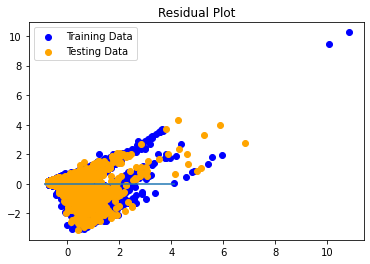

In [62]:
# Sub-Task 4: Do Linear Regression and Plot it

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [63]:
# Sub-Task 5: Determine MSE and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.4406435110317249, R2: 0.5995073983924271
